In [1]:
import sys
import numpy as np 
import pandas as pd 
sys.path.append('..')
from src.proxies import gBisg, mlBisg
from src.datasets import HMDA 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

/Users/kaggrey/Documents/research/proxies/experiments/../src/datasets.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  targets = self.data["derived_race"].replace(self.map_to_index)


In [2]:
gbisg = gBisg()
hmda = HMDA("../data/hmda/hmda.csv", gbisg, outcome=True)
X_train, X_test, Y_train, Y_test, B_train, B_test = hmda.get_data(split=.5, return_bisg=True)

/Users/kaggrey/Documents/research/proxies/experiments/../src/datasets.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  targets = self.data["derived_race"].replace(self.map_to_index)


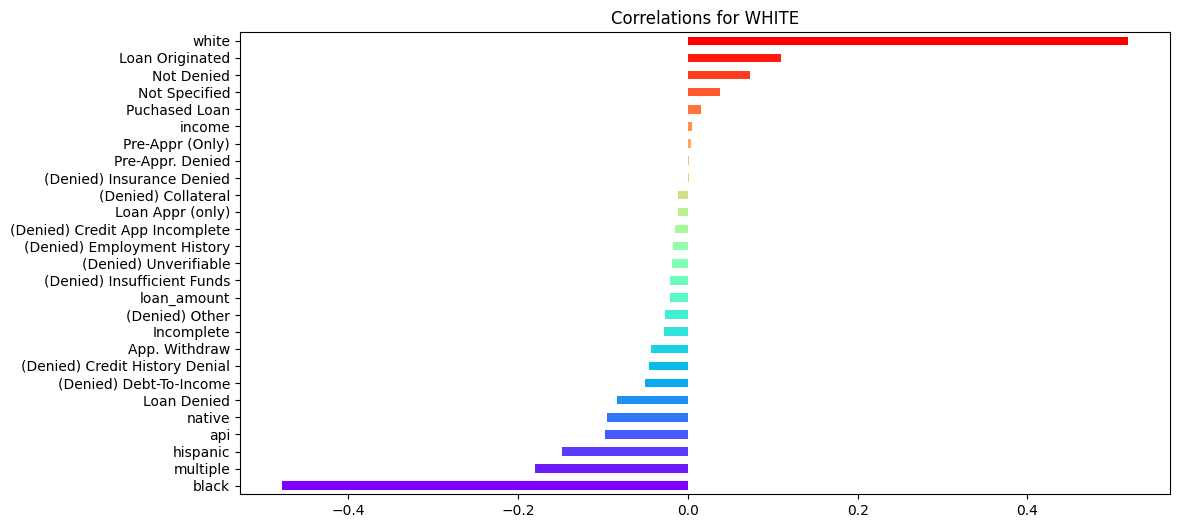

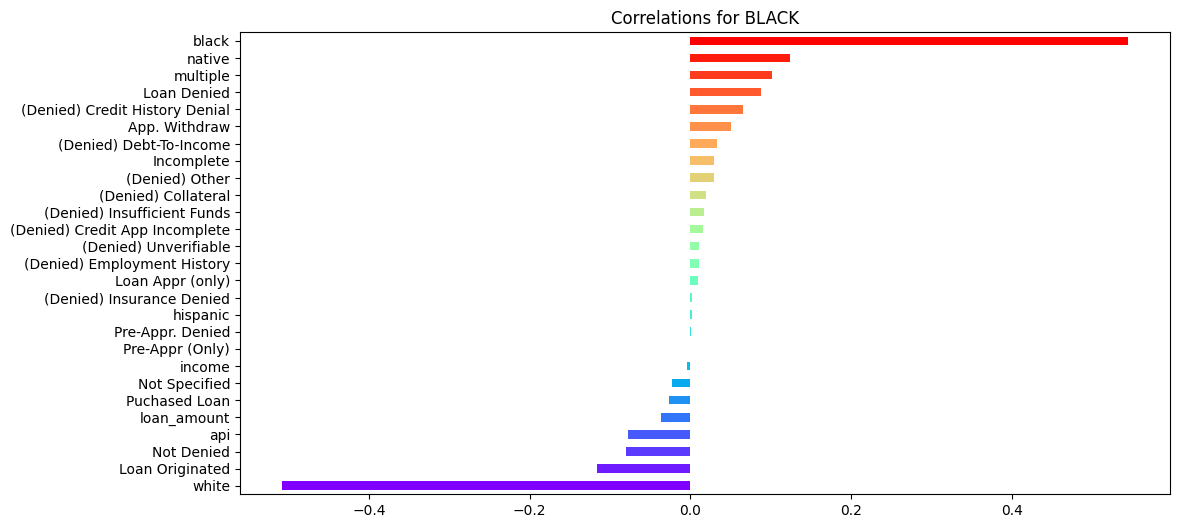

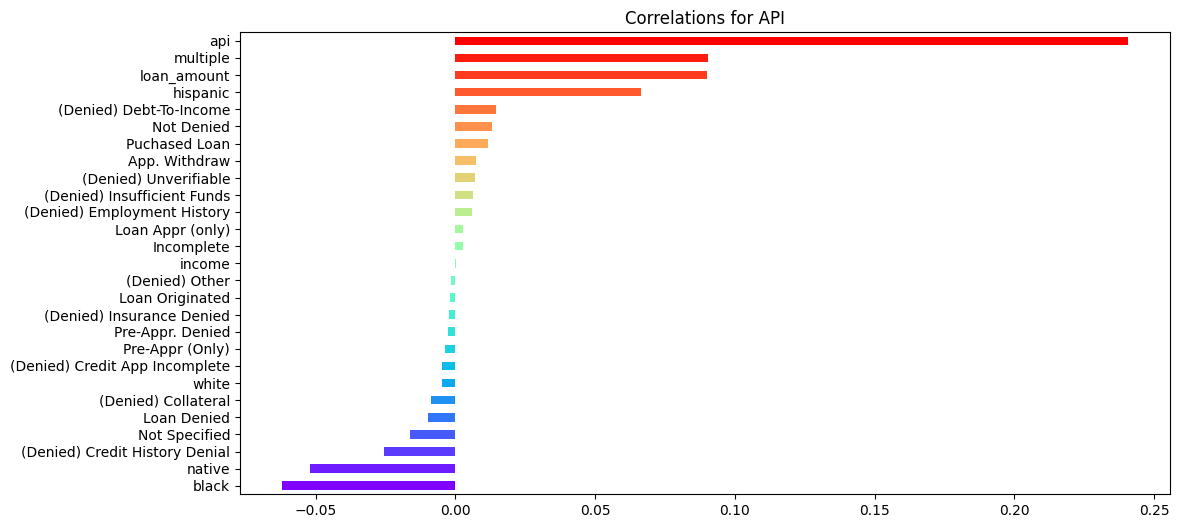

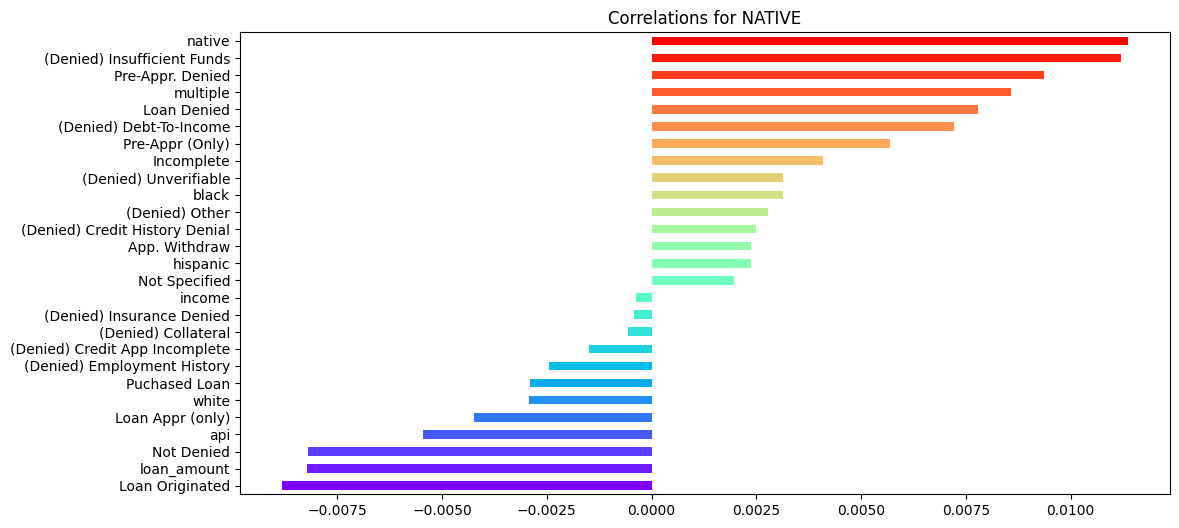

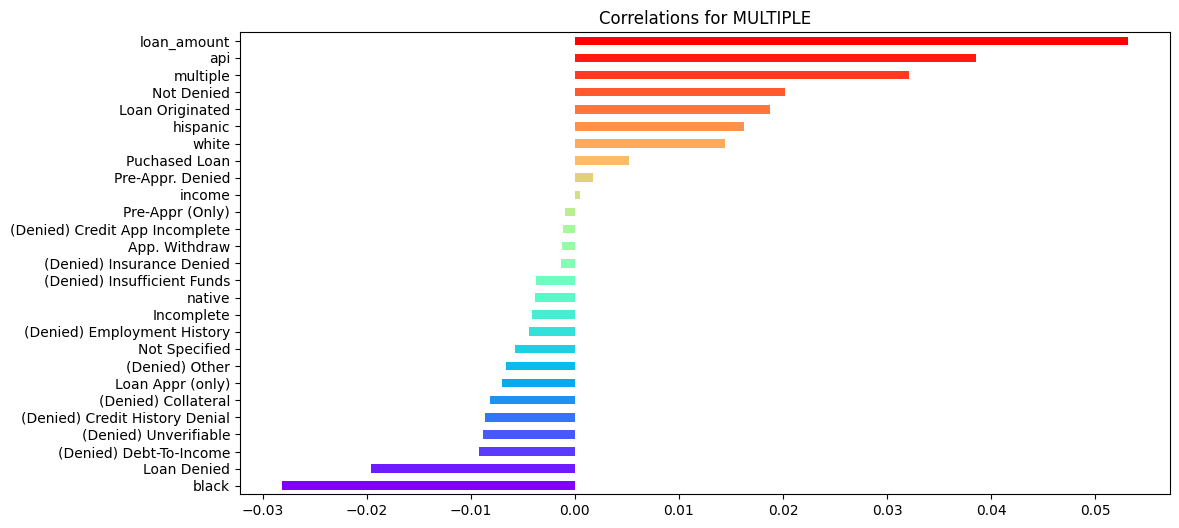

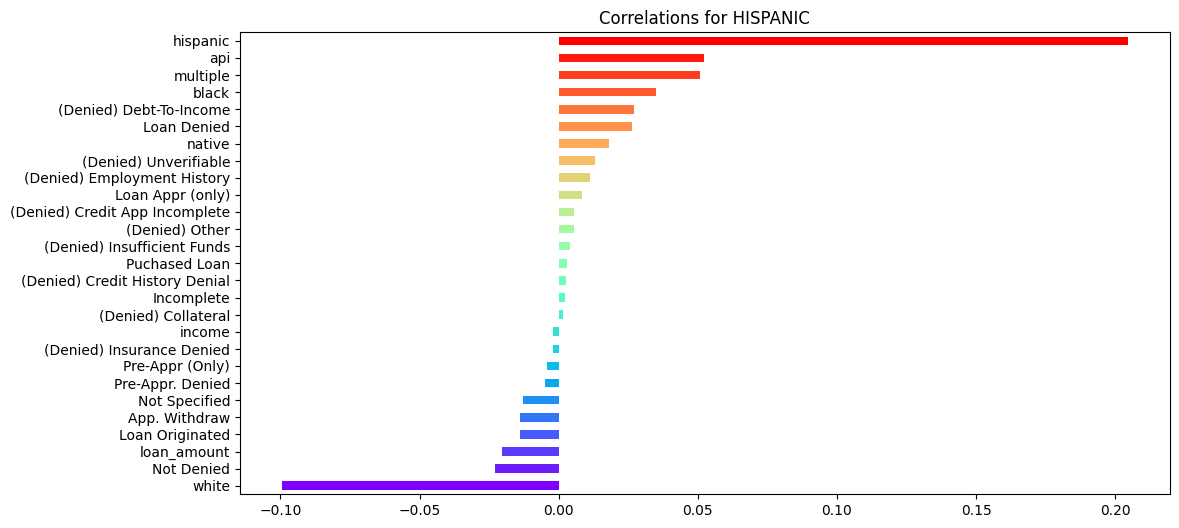

<Figure size 640x480 with 0 Axes>

In [3]:
n_fts = len(X_train.columns)
colors = cm.rainbow(np.linspace(0, 1, n_fts))

for i in range(6):
    X_train.corrwith(Y_train == i, axis=0).sort_values(ascending=True).plot(
        kind='barh',
        color=colors, 
        figsize=(12, 6)
    )
    plt.title('Correlations for ' + B_train.columns[i].upper())
    plt.show()
    plt.clf()

In [4]:
mlbisg = mlBisg("mr")
mlbisg.train(X_train,Y_train)

In [4]:
race_given_originated_truth = Y_test[mask].replace(hmda.map_to_race).value_counts()
print(race_given_originated_truth/race_given_originated_truth.sum())
print("n")

derived_race
white       0.559518
black       0.261501
api         0.078111
hispanic    0.067829
multiple    0.030908
native      0.002134
Name: count, dtype: float64
n


In [5]:
B_test[mask].sum()/B_test[mask].sum().sum()

white       0.605284
black       0.255991
api         0.049315
native      0.002453
multiple    0.021429
hispanic    0.065529
dtype: float64

In [5]:
lr_pred = mlbisg.inference(X_test[mask]) 
lr_pred.sum(axis=0)/lr_pred.sum()

NameError: name 'mask' is not defined

In [5]:
reults = pd.DataFrame({
    
})

SyntaxError: invalid syntax (1665253662.py, line 1)